Link to the competition: https://tianchi.aliyun.com/competition/entrance/231705/introduction

In [558]:
import sys
import pickle
import warnings
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import pandas as pd 
import json
import seaborn as sns
from keras import optimizers
import matplotlib.pyplot as plt
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS  # import stop words from language data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from utils.plot_functions import *
%matplotlib inline
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_colwidth', 500)
%load_ext autoreload
%autoreload 2
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [474]:
df_train = pd.read_table('./data/[Updated] Training Set for Competition.txt',sep='\t')

In [475]:
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d.%m.%Y').dt.date
df_train['Event ID'] = df_train['Event ID'].fillna(0)
df_train['Is_Food'] = df_train['Event ID'] > 0

In [476]:
df_train.head(3)

,Date,Time,Trainig/Test,Event ID,Title,Link,Abstract,Is_Food
0,2019-02-05,18:45:44,Training,1.0,New dog food recall and latest warning on grain-free foods #SmartNews,https://twitter.com/tweet/status/1092857075753861125,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,True
1,2019-02-05,06:29:38,Training,1.0,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L,https://twitter.com/tweet/status/1092671572400373760,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L https://t.co/5XcIAt9g4p,True
2,2019-02-05,18:40:20,Training,1.0,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News,https://twitter.com/tweet/status/1092855599233150977,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News https://t.co/z0w17ubVay,True


In [477]:
df_test = pd.read_table('./data/[Updated] Test Set for Competition.txt',sep='\t')

In [478]:
df_test.head(3)

,Date,Time,Training/Test,Title,Link,Abstract
0,2019-03-07,23:59:31,Test,@pccs_heron Salmonella,https://twitter.com/tweet/status/1103807421800202242,@pccs_heron Salmonella
1,2019-03-07,23:59:20,Test,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal…,https://twitter.com/tweet/status/1103807373196623873,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal… https://t.co/8ziThZHccA
2,2019-03-07,23:59:02,Test,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the…,https://twitter.com/tweet/status/1103807299389349889,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the… https://t.co/XoMGCuQLcs


# Extract tweet info based on id

In [ ]:
!pip install Twython

In [470]:
from twython import Twython
with open('api_key.txt','r') as inf:
    key_dict = eval(inf.read())

In [472]:
CONSUMER_KEY = key_dict['CONSUMER_KEY']
CONSUMER_SECRET = key_dict['CONSUMER_SECRET']
OAUTH_TOKEN = key_dict['OAUTH_TOKEN']
OAUTH_TOKEN_SECRET = key_dict['OAUTH_TOKEN_SECRET']
twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

In [663]:
def add_more_info(tweet_id):
    r = {
        'tweet_found':True,
        'user_name':'',
        'mentions':[],
        'medias':None,
        'hashtags':[],
        'in_reply_to_status_id':None,
        'in_reply_to_screen_name':None,
        'in_reply_to_status_text':None
    }
    
    if tweet_id == -1:
        return r
    try:
        tweet = twitter.show_status(id=tweet_id)
    except:
        r['tweet_found'] = False
        return r
    
    r['user_name'] = tweet['user']['name']
    r['mentions'] = [v for mention in tweet['entities']['user_mentions'] for k,v in mention.items() if k == 'screen_name'] 
    try:
        r['medias'] = [v for media in tweet['entities']['media'] for k,v in media.items() if k == 'media_url']
    except:
        pass
    r['hashtags'] = [v for mention in tweet['entities']['hashtags'] for k,v in mention.items() if k == 'text']
    r['in_reply_to_status_id'] = tweet['in_reply_to_status_id']
    r['in_reply_to_screen_name'] = tweet['in_reply_to_screen_name']
    if r['in_reply_to_status_id'] is not None:
        try:
            main_tweet = twitter.show_status(id=r['in_reply_to_status_id'])
            r['in_reply_to_status_text'] = main_tweet['text']
        except:
            pass
    
    return r

In [668]:
def extract_tweet_id(link):
    try:
        return int(link.split('/')[-1])
    except:
        return -1

In [674]:
df_test['tweet_id'] = df_test['Link'].apply(extract_tweet_id)
extra_infos = []

In [675]:
for tweet_id in log_progress(df_test['tweet_id'] , every = 1):
    extra_infos.append(add_more_info(tweet_id))

In [700]:
df_extra_infos = pd.DataFrame(extra_infos[:600])
df_test_merge = pd.concat([df_test[:600], df_extra_infos], axis = 1)
df_test_merge.to_csv('first_600_in_test.csv', index = False)

# Distribution

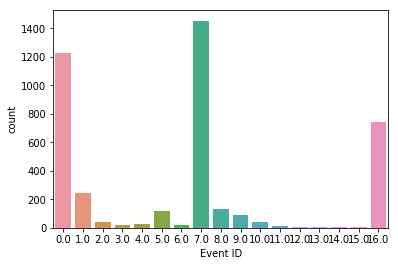

In [479]:
sns.countplot(x='Event ID', data=df_train)

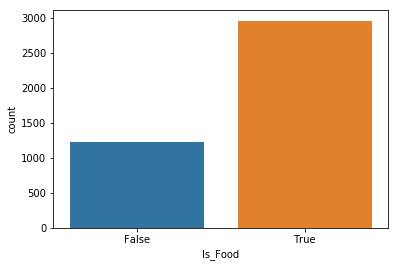

In [480]:
sns.countplot(x='Is_Food', data=df_train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

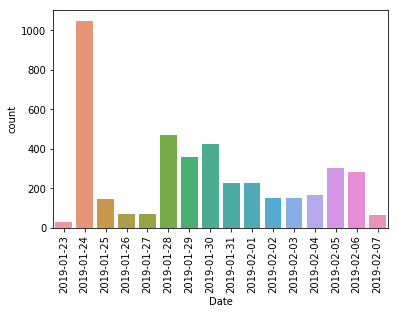

In [481]:
sns.countplot(x='Date', data=df_train, order = sorted(set(df_train['Date'])))
plt.xticks(rotation=90)

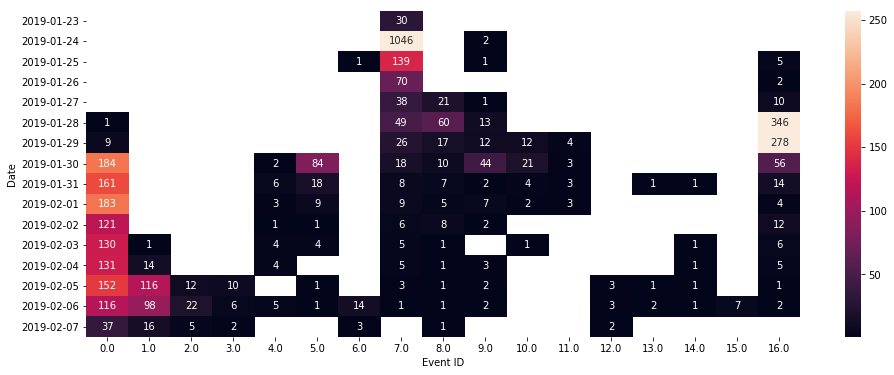

In [482]:
plt.figure(figsize=(16, 6))
pivot = df_train.groupby(['Date','Event ID'], as_index=False)['Link'].\
            agg({'count':len}).\
            pivot('Date','Event ID','count')
sns.heatmap(pivot, robust=True, annot=True, fmt='.4g')

# NLP on Abstract

## Remove stop words, and tokenize

In [535]:
stop_words_getter = lambda token: token.is_stop or token.lemma_ in STOP_WORDS
Token.set_extension('is_stop', getter=stop_words_getter, force=True)  # set attribute with getter

In [594]:
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num or \
       not token.text.isalpha() or \
       token.lemma_ == '-PRON-' or \
       'http' in token.text or \
       '@' in token.text or \
       "’s" in token.text or \
       "'s" in token.text or \
       token.text == 'rt' or \
       len(token.text) <= 1 or \
       token._.is_stop):
        return(False)
    else:
        return(True)

In [595]:
def clean(text):
    return [token.lemma_ for token in nlp(str(text).lower()) if filter_token(token)]

In [596]:
%%time
temp = []
for text in log_progress(df_train['Abstract'], every = 100):
    temp.append(clean(text))
df_train['ab_clean'] = temp

CPU times: user 3min 19s, sys: 28 s, total: 3min 47s
Wall time: 38.6 s


In [597]:
df_train.to_csv('train.csv', index=False)

In [598]:
df_test.to_csv('test.csv', index=False)

---
***Below not updated ***04/11

In [46]:
%%time
df_test['ab_clean'] = df_test['Abstract'].apply(clean)

CPU times: user 16min 44s, sys: 2min 14s, total: 18min 59s
Wall time: 3min 13s


In [592]:
df_train[['Abstract','ab_clean']].head(3)

,Abstract,ab_clean
0,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,"[new, dog, food, recall, late, warning, grain, free, food, smartnew]"
1,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L https://t.co/5XcIAt9g4p,"[new, dog, food, recall, late, warning, grain, free, food]"
2,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News https://t.co/z0w17ubVay,"[dog, food, recall, dangerous, level, vitamin, fox, news]"


## Apply Phrase model

In [219]:
bigram_model = Phraser(Phrases(list(df_train['ab_clean']) + list(df_test['ab_clean'])))

In [220]:
df_train['ab_clean_ph'] = df_train['ab_clean'].apply(lambda text: bigram_model[text])
df_test['ab_clean_ph']  = df_test['ab_clean'].apply(lambda text: bigram_model[text])

In [221]:
df_train[['Abstract','ab_clean','ab_clean_ph']].head(3)

,Abstract,ab_clean,ab_clean_ph
0,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,"[new, dog, food, recall, late, warning, grain, free, food, smartnews]","[new, dog_food, recall, late_warning, grain_free, food, smartnews]"
1,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L https://t.co/5XcIAt9g4p,"[new, dog, food, recall, late, warning, grain, free, foods]","[new, dog_food, recall, late_warning, grain_free, foods]"
2,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News https://t.co/z0w17ubVay,"[rt, dog, food, recall, dangerous, level, vitamin, d, fox, news]","[rt, dog_food, recall, dangerous_level, vitamin_d, fox_news]"


In [222]:
df_test[['Abstract','ab_clean','ab_clean_ph']].head(3)

,Abstract,ab_clean,ab_clean_ph
0,@pccs_heron Salmonella,[salmonella],[salmonella]
1,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal… https://t.co/8ziThZHccA,"[feace, polio, virus, transmit, feacal]","[feace, polio, virus, transmit, feacal]"
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the… https://t.co/XoMGCuQLcs,"[think, allergic, water]","[think, allergic, water]"


In [223]:
' / '.join(set([word for text in df_train['ab_clean_ph'] for word in text if '_' in word ]))[:200]

'california_possible / gluten_free / government_chemist / scientist_choose / science_diet / outbreak_cause / allergic_reaction / wednesday_source / united_states / market_share / rubber_u.s. / check_pa'

## Highlight zero length abstract

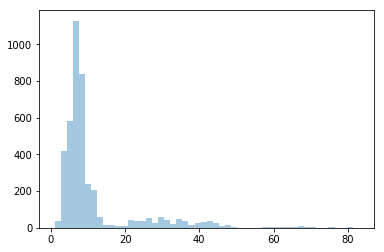

In [431]:
sns.distplot([len(x) for x in df_train['ab_clean_ph']], kde = False)

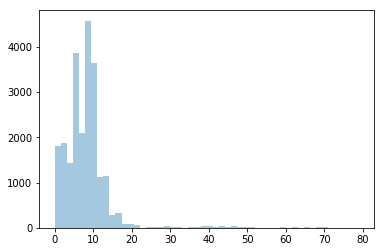

In [432]:
sns.distplot([len(x) for x in df_test['ab_clean_ph']], kde = False)

In [435]:
df_train['zero_length'] = df_train['ab_clean_ph'].apply(lambda x: True if len(x) == 0 else False)
df_test['zero_length'] = df_test['ab_clean_ph'].apply(lambda x: True if len(x) == 0 else False)

In [436]:
print(sum(df_train['zero_length']), 'zero length cleaned abstract in training set.')
print(sum(df_test['zero_length']), 'zero length cleaned abstract in test set.')

0 zero length cleaned abstract in training set.
1158 zero length cleaned abstract in test set.


In [437]:
df_test = df_test[~df_test['zero_length']]

# Binary Classification Model on `Is_Food`

**Generate TF-IDF matrix**

In [438]:
vectorizer = TfidfVectorizer(min_df=3, sublinear_tf=True, max_df=0.5)
corpus = list(df_train['ab_clean_ph']) + list(df_test['ab_clean_ph'])
vectorizer.fit([' '.join(text) for text in corpus])
X_train  = vectorizer.transform([' '.join(text) for text in df_train['ab_clean_ph']])
X_test = vectorizer.transform([' '.join(text) for text in df_test['ab_clean_ph']])
y_train = df_train['Is_Food'].apply(lambda x: 1 if x else 0)

In [439]:
x_columns = [word for word, index in sorted(vectorizer.vocabulary_.items(), key = lambda x:x[1])]

**Fit Regularized Logistic Regression**

In [440]:
param_test_lr =  {'C' :[10 ** x for x in list(range(-3,4,1))]}
param_test_lr['C']

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [441]:
gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l2', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
        scoring = {'AUC': 'roc_auc'},
        cv = 5,
        n_jobs = 4, 
        refit = 'AUC')

In [442]:
gsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)

**Take a look at impact of penalty param**

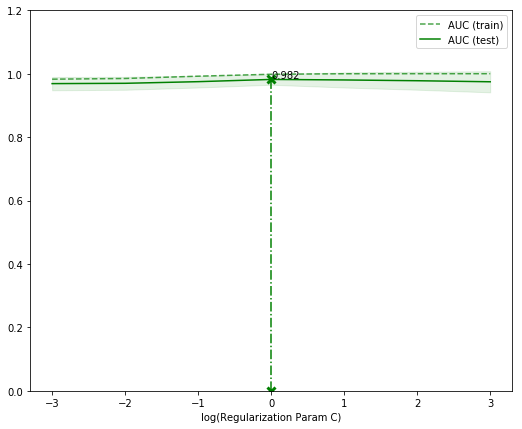

In [443]:
plot_auc(gsearch_lr)

**Refit the model with best C**

In [444]:
best_C = gsearch_lr.best_params_['C']
print('The best C is '+ str(best_C))

The best C is 1


In [445]:
best_AUC_lr = gsearch_lr.best_score_
print('The best AUC is '+ str(best_AUC_lr))

The best AUC is 0.9819168190825991


In [446]:
lr_ = LogisticRegression(penalty='l2', solver='liblinear', C=best_C, max_iter=1000,class_weight = 'balanced')
lr_ = lr_.fit(X = X_train, y = y_train)

**Investigate Coefficients**

In [447]:
coef_df = pd.DataFrame({'variable':x_columns, 'coefficient':lr_.coef_[0]})
coef_df.sort_values(by = 'coefficient').head(10)

,variable,coefficient
8124,salmonella,-3.955952
6620,outbreak,-2.791177
3619,food,-2.632672
1660,chicken,-2.266344
2125,cookie_dough,-1.659985
5808,meat,-1.595315
2980,egg,-1.571553
3453,february,-1.549830
4440,homemade,-1.448662
2921,eat_raw,-1.435206


In [448]:
coef_df.sort_values(by = 'coefficient').tail(10)

,variable,coefficient
7639,recall_alert,2.667288
6272,nectarine,2.905514
6797,peach_nectarine,3.220918
4059,gold_medal,3.352740
4392,hill_,3.375992
1664,chicken_nugget,3.380572
838,baby_spinach,3.939374
3586,flour,4.519159
3957,general_mills,6.334347
7636,recall,6.433351


**Apply to test set**
- Without zero length abstracts

In [449]:
print('There is a total of', len(df_test), 'in cleaned test set')
pred_probs = [x[1] for x in lr_.predict_proba(X_test)]
preds = lr_.predict(X_test)
print('There is a total of', sum(preds), 'predicted to be food-related events')

There is a total of 21682 in cleaned test set
There is a total of 1310 predicted to be food-related events


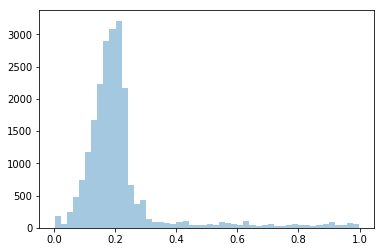

In [450]:
sns.distplot(pred_probs, kde = False)

# (Not used) Baseline of supervised model

In [255]:
vectorizer = TfidfVectorizer(min_df=2, sublinear_tf=True)

In [267]:
text_tfidf = vectorizer.fit_transform([' '.join(text) for text in df_train['ab_clean_ph']])
X_train = text_tfidf
y_train = df_train['Event ID']

In [269]:
param_test_lr =  {'C' :[10 ** x for x in list(range(-4,5,1))]}
param_test_lr['C']
gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
    cv = 5,
    n_jobs = 4)

gsearch_lr.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [274]:
gsearch_lr.best_params_

{'C': 1000}

In [273]:
gsearch_lr.best_score_

0.9792015300023906